# Trabajo Practico Integrador

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types).
* Todos los gráficos deben tener correctamente etiquetados los ejes.


## Alumnos
* <Nombre, Apellido>
* <Nombre, Apellido>

## Librerias utilizadas
Agregar todas las librerias utilizadas

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

## Primer Entrega

* Fecha:

### Función de sintetización de ruido rosa
El ruido rosa o ruido $\frac{1}{\sqrt{f}}$ , dónde $f$ denota frecuencia en Hz, es un ruido con una distribución de frecuencias tal que su densidad espectral de potencia es proporcional a la inversa de la frecuencia. Esto implica que su nivel, por bandas de tercio de octava, es constante. El nivel del ruido rosa por intervalo fijo de frecuencias va decayendo a razón de 3 dB/octava, de forma no lineal aunque las frecuencias se representan en un eje lineal.

![Espectro del ruido rosa](../img/image44.png)

Se adjunta a continuación una función que devuelva un ruido rosa sintetizado a partir del algoritmo de Voss y Clarke (pueden encontrar mas informacion en [este enlace](https://www.dsprelated.com/showabstract/3933.php) y en [este notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)). Modificar la función para que reciba como parametro la duración del ruido en segundos $t$ y como parametro opcional la frecuencia de muestreo $fs$ (la longitud del mismo sera el producto entre ambos). Adjuntar grafico del resultado

In [ ]:
def voss(nrows, ncols=16):
    """
    Genera ruido rosa utilizando el algoritmo de Voss-McCartney(https://www.dsprelated.com/showabstract/3933.php).
    
    nrows: numero de valores a generar
    rcols: numero de fuentes a aleatorias a agregar
    
    returns: NumPy array
    """
    
    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # el numero total de cambios es nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)
    
    #Implementacion del foward fill en numpy (opcional)
#     mask = np.isnan(array)
#     idx = np.where(~mask,np.arange(mask.shape[1]),0)
#     np.maximum.accumulate(idx,axis=1, out=idx)
#     array[mask] = array[np.nonzero(mask)[0], idx[mask]]
#     total = np.sum(array,axis=1)
    
    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1)
    

    ## Centrado de el array en 0
    total = total - total.mean()
    
    ## Normalizado
    valor_max = max(abs(max(total)),abs(min(total)))
    total = total / valor_max
    
    return total

Llamar la función.

In [ ]:
# completar

Graficar el dominio temporal del resultado.

In [ ]:
# completar

Graficar el dominio espectral del resultado.

In [ ]:
https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520

In [12]:
def FFTPlot (audio, fs):
    # Normalizando los valores
    audio = audio / (2.**15)
    # Extraer longitud
    len_audio = len(audio)
    # Aplicando la transformada de Fourier
    transformed_signal = np.fft.fft(audio)
    half_length = int(np.ceil((len_audio + 1) / 2.0))
    transformed_signal = abs(transformed_signal[:half_length])
    transformed_signal /= float(len_audio)
    transformed_signal **= 2
    # Extraer la longitud de la señal transformada
    len_ts = len(transformed_signal)

    # Casos pares e impares
    if len_audio % 2:
        transformed_signal[1:len_ts] *= 2
    else:
        transformed_signal[1:len_ts-1] *= 2

    # Extrayendo la potencia en decibeles dB
    power = 10 * np.log10(transformed_signal)

    # Construyendo el eje del tiempo
    x_values = np.arange(half_length, 1) * (fs / len_audio) / 1000.0

    # Graficando
    plt.figure()
    plt.plot(power, color='black')
    plt.xlabel('Frecuencia [kHz]')
    plt.ylabel('Potencia [dB]')
    plt.show()

In [9]:
# completar

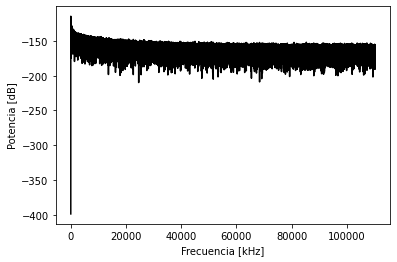

In [13]:
from scipy.io import wavfile
# Leyendo el archivo input_freq
fs, audio = wavfile.read('prueba.wav')
FFTPlot (audio, fs)

Un **método alternativo** es utilizando un filtro en el siguiente [link](https://ccrma.stanford.edu/~jos/sasp/Example_Synthesis_1_F_Noise.html) se presenta la implementación en Matlab/Octave.

### Sine Sweep
El sine sweep es el método más indicado para generar el impulso por medio de la convolución (Nikolić, I., and O. H. Bjor, 2003). Dado que métodos tales como: explosión de globo, aplauso, disparo con pistola se salva, paper gun (Paper Popper, https://en.wikipedia.org/wiki/Paper_popper), golpe entre maderas, petardos, entre otros, carecen de reproducibilidad. Esto es debido a su nivel sonoro, duración y características espectrales, además de una muy baja relación señal ruido, la cual difícilmente se solucione filtrando o promediando con muchas mediciones. Comencemos por ver cómo generar el sine sweep logarítmico $x(t)$ que posee la siguiente forma:

\begin{equation}
f(x) = \sin[\theta(t)]= \sin[K (e^\frac{t}{L} - 1) ]
\tag{1}
\end{equation}

Donde:

\begin{equation}
K = \frac{T w_{1}}{R}
\end{equation}

\begin{equation}
L = \frac{T}{R}
\end{equation}

y el Sweep Rate $R$
\begin{equation}
R = \ln \left( \frac{w_{2}}{w_{1}} \right)
\end{equation}

Con $w_{1}$ y $w_{2}$, las frecuencias angulares inferior y superior respectivamente, $T$ es el tiempo de duración del sine sweep en segundos (Meng, Q., 2008). Si estudiamos el espectro de la señal de la ecuación (1), se observa que no es plano, sino que disminuye a razón de -3 dB/octava, como el ruido rosa (Ver fig. 2, sup). De modo que el espectro de $x(-t)$ debe ser ajustado, aumentando en 3 dB/octava, de modo que cuando realizamos el cálculo se restaure la plenitud perfecta de la respuesta de impulso medida $h(t)$ (Farina A., 2000) (Ver fig. 2, inf).
![](../../img/image43.png)

<center><b>Fig 2.</b> Espectro del sine sweep. Sine sweep logarítmico  (sup). Filtro invertido (inf).</center>


En el dominio temporal las señales del sine sweep logarítmico y el filtro inverso se comportan de la siguiente manera (Ver fig. 3). 
![](../../img/image46.png)

<center><b>Fig 3.</b> Magnitud del sine sweep. Sine sweep logarítmico (sup). Filtro invertido (inf).</center>


Para generar el filtro inverso $k(t)$ del sine sweep logarítmico $x(t)$ se requiere de una modulación $m(t)$ definida por la siguiente expresión:

\begin{equation}
m(t) = \frac{w_{1}}{2\pi w(t)}
\tag{2}
\end{equation}

Obtenida de la frecuencia instantánea (dado que la amplitud cambia en función de la
frecuencia), calculada a partir de la ecuación (1):

\begin{equation}
w(t)=\frac{d[\theta (t)]}{dt}=\frac{K}{L} e^\frac{t}{L}
\tag{3}
\end{equation}

entonces, el filtro inverso $k(t)$ queda definido como:

\begin{equation}
k(t)=m(t)x(-t)
\tag{4}
\end{equation}

A continuación se adjunta una posible función generadora de un sine sweep. Se pide a los alumnos completarla para generar el filtro inverso de el mismo, a partir de las ecuaciones descriptas anteriormente, y graficar el resultado de ambos filtros. Agregar la documentacion necesaria, tomando como referencia la funcion anterior

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
def sineSweep(T=3,f1=10,f2=100,fs=1000):
    
    t = np.arange(0, T*fs)/fs
    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2
    R = np.log(w2/w1)
    K = T*w1/R
    L = T/R
    
    # Generacion del sweep exponencial
    x = np.sin(K*(np.exp(t/L)-1))
    
    # Generacion del filtro inverso
    # Agregar codigo aqui
    

## Extra: Reproducción y Grabación Simultanea de audio 
La función tiene que permitir la reproducción y la adquisición de manera simultánea para un tiempo determinado por el
usuario. Es importante evaluar y constatar dicha simultaneidad. El módulo debería permitir seleccionar el hardware a utilizar. Algunos articulos de interes para el desarrollo:
* [Sound Device - Simultaneous Playback and Recording](https://python-sounddevice.readthedocs.io/en/0.4.1/usage.html#simultaneous-playback-and-recording)
* [Playing and Recording Sound in Python](https://realpython.com/playing-and-recording-sound-python/)
* [Audio in Python](https://wiki.python.org/moin/Audio/)
* [https://github.com/spatialaudio/python-sounddevice/issues/148](https://github.com/spatialaudio/python-sounddevice/issues/148)